In this lab, we are going to experiment with a subset of UCI's Chronic Kidney Disease data set, a collection of samples taken from patients in India over a two month period, some of whom were in the early stages of the disease.

We will carry this analysis with the three main variables in the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
from sklearn.decomposition import PCA
import math
import pandas as pd
from sklearn import preprocessing

# Look pretty...
plt.style.use('ggplot')

scaleFeatures_value = True

PCA requires data to be standardized -- in other words it's mean should be equal to 0, and it should have unit variance. Feature scaling is the type of transformation that only changes the scale and not number of features, so we'll use the original dataset column names. Below is a function to help us perform feature scaling.

In [2]:
def scaleFeatures(df):
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    print ("New Variances:\n", scaled.var())
    print ("New Describe:\n", scaled.describe())
    return scaled

The funtion below will project the original features onto the principal component feature-space.

In [3]:
def drawVectors(transformed_features, components_, columns, plt, scaled):
    if not scaled:
        return plt.axes()

    num_columns = len(columns)

    # Scaling the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    #
    # Visualizing projections
    # Sorting each column by it's length. These are the original
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print ("Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        # We use an arrow to project each original feature as a
        # labeled vector on the principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

In [4]:
# Loading up the dataset 
df = pd.read_csv("Datasets\\kidney_disease.csv", sep=',', header= 0)
print(df.head(2))

   id   age    bp    sg   al   su  rbc      pc         pcc          ba  \
0   0  48.0  80.0  1.02  1.0  0.0  NaN  normal  notpresent  notpresent   
1   1   7.0  50.0  1.02  4.0  0.0  NaN  normal  notpresent  notpresent   

       ...        pcv    wc   rc  htn   dm  cad appet  pe ane classification  
0      ...         44  7800  5.2  yes  yes   no  good  no  no            ckd  
1      ...         38  6000  NaN   no   no   no  good  no  no            ckd  

[2 rows x 26 columns]


With every dataset, the first thing one should do is find out as much about it as possible, both by reading up on any metadata, as well as by prodding through the actual data. Particularly, pay attention to what the docs say about these three variables: bgr, rc, and wc.

Let us now explore the variables in the dataset and understand their distribution and data types.

In [5]:
# Exploring the numerical data
print(df.describe())

               id         age          bp          sg          al          su  \
count  400.000000  391.000000  388.000000  353.000000  354.000000  351.000000   
mean   199.500000   51.483376   76.469072    1.017408    1.016949    0.450142   
std    115.614301   17.169714   13.683637    0.005717    1.352679    1.099191   
min      0.000000    2.000000   50.000000    1.005000    0.000000    0.000000   
25%     99.750000   42.000000   70.000000    1.010000    0.000000    0.000000   
50%    199.500000   55.000000   80.000000    1.020000    0.000000    0.000000   
75%    299.250000   64.500000   80.000000    1.020000    2.000000    0.000000   
max    399.000000   90.000000  180.000000    1.025000    5.000000    5.000000   

              bgr          bu          sc         sod         pot        hemo  
count  356.000000  381.000000  383.000000  313.000000  312.000000  348.000000  
mean   148.036517   57.425722    3.072454  137.528754    4.627244   12.526437  
std     79.281714   50.503006 

In [6]:
# Exploring the categorical data
print(df.describe(include=['O']))

           rbc      pc         pcc          ba  pcv    wc   rc  htn   dm  cad  \
count      248     335         396         396  330   295  270  398  398  398   
unique       2       2           2           2   44    92   49    2    5    3   
top     normal  normal  notpresent  notpresent   52  9800  5.2   no   no   no   
freq       201     259         354         374   21    11   18  251  258  362   

       appet   pe  ane classification  
count    399  399  399            400  
unique     2    2    2              3  
top     good   no   no            ckd  
freq     317  323  339            248  


In [7]:
# Checking the data types
print(df.dtypes)

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


We observe that all the variables except id and classification have missing values in them. There are different ways to treat missing values depending upon whether it belongs to a numerical variable category or a cetegorical variable category. Over here, we will drop all the rows that have any nans.

In [8]:
# Dropping all the nans
df = df.dropna(axis = 0)

Before moving ahead, let us quickly go through our data again and check the number of oberservations left, the data types of each variable etc.

In [9]:
# Exploring the numerical data
print(df.describe())

               id         age          bp          sg          al          su  \
count  158.000000  158.000000  158.000000  158.000000  158.000000  158.000000   
mean   274.841772   49.563291   74.050633    1.019873    0.797468    0.253165   
std    102.998517   15.512244   11.175381    0.005499    1.413130    0.813397   
min      3.000000    6.000000   50.000000    1.005000    0.000000    0.000000   
25%    243.000000   39.250000   60.000000    1.020000    0.000000    0.000000   
50%    298.500000   50.500000   80.000000    1.020000    0.000000    0.000000   
75%    355.750000   60.000000   80.000000    1.025000    1.000000    0.000000   
max    399.000000   83.000000  110.000000    1.025000    4.000000    5.000000   

              bgr          bu          sc         sod         pot        hemo  
count  158.000000  158.000000  158.000000  158.000000  158.000000  158.000000  
mean   131.341772   52.575949    2.188608  138.848101    4.636709   13.687342  
std     64.939832   47.395382 

In [10]:
# Exploring the categorical data
print(df.describe(include=['O']))

           rbc      pc         pcc          ba  pcv    wc   rc  htn   dm  cad  \
count      158     158         158         158  158   158  158  158  158  158   
unique       2       2           2           2   34    71   41    2    2    2   
top     normal  normal  notpresent  notpresent   52  7200  4.5   no   no   no   
freq       140     129         144         146   15     7   12  124  130  147   

       appet   pe  ane classification  
count    158  158  158            158  
unique     2    2    2              2  
top     good   no   no         notckd  
freq     139  138  142            115  


In [11]:
# Checking the data types
print(df.dtypes)

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


In [12]:
# Creating color coded labels since the actual label feature
# will be removed prior to executing PCA
labels = ['red' if i=='ckd' else 'green' for i in df.classification]

Now, using an appropriate indexer command we will select only the following columns: bgr, rc, and wc

Also we will check the dtypes of our dataframe. Anything that didn't make it to the right type, we will investigate by looking through the data and identifying why the conversion failed. These types of problems often arise when we aren't in control of how the data is organized.

In [13]:
# Indexing to select columns
mdf = df.loc[:,['bgr','wc','rc']]
print(mdf.dtypes)

bgr    float64
wc      object
rc      object
dtype: object


In [14]:
# Printing out and checking the dataframe's dtypes. 
mdf = mdf.apply(pd.to_numeric, args=('coerce',))
print(mdf.dtypes)

bgr    float64
wc       int64
rc     float64
dtype: object


In [15]:
# Checking the mean, variance etc of the variables in the dataset
print(mdf.var(axis=0))

print(mdf.describe())

bgr    4.217182e+03
wc     9.777380e+06
rc     1.039104e+00
dtype: float64
              bgr            wc          rc
count  158.000000    158.000000  158.000000
mean   131.341772   8475.949367    4.891772
std     64.939832   3126.880181    1.019364
min     70.000000   3800.000000    2.100000
25%     97.000000   6525.000000    4.500000
50%    115.500000   7800.000000    4.950000
75%    131.750000   9775.000000    5.600000
max    490.000000  26400.000000    8.000000


Reducing the dataset to two principal components by running it through PCA, then check out the resulting visualization.

Scaling Features

New Variances:
 bgr    1.006369
wc     1.006369
rc     1.006369
dtype: float64
New Describe:
                 bgr            wc            rc
count  1.580000e+02  1.580000e+02  1.580000e+02
mean  -4.497106e-17 -4.497106e-17  1.349132e-16
std    1.003180e+00  1.003180e+00  1.003180e+00
min   -9.475974e-01 -1.500159e+00 -2.747446e+00
25%   -5.305059e-01 -6.259123e-01 -3.855519e-01
50%   -2.447210e-01 -2.168611e-01  5.730335e-02
75%    6.306235e-03  4.167672e-01  6.969831e-01
max    5.540492e+00  5.750474e+00  3.058878e+00
Features by importance:
 [(3.9998071556884813, 'wc'), (3.2588876641210884, 'bgr'), (3.009752752998365, 'rc')]


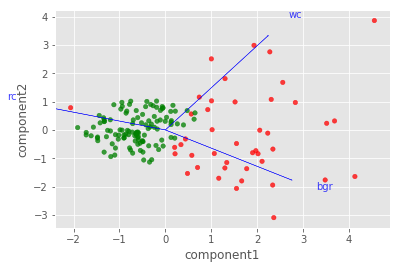

In [16]:
if scaleFeatures_value: 
    print("Scaling Features\n")
    mdf = scaleFeatures(mdf)
    
# Running PCA on the dataset and reducing it to 2 components
pca = PCA(n_components = 2)
pca.fit(mdf)
T = pca.transform(mdf)

# Converting to a Pandas Dataframe.
# Note: Since we transformed via PCA, we no longer have column names.
ax = drawVectors(T, pca.components_, mdf.columns.values, plt, scaleFeatures_value)
T = pd.DataFrame(T)
T.columns = ['component1', 'component2']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=0.75, ax=ax)
plt.show()